## Setup

<div class="girk">
Do we actually need pandas?
I guess at some point we should check that we really use all this imports</div><i class="fa fa-lightbulb-o "></i>

In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import pandas as pd
import time

## Load IRFs

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import (
    EffectiveAreaTable2D,
    EnergyDispersion2D,
    EnergyDependentMultiGaussPSF,
    Background3D,
)
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap
from gammapy.spectrum import models
from gammapy.image.models import SkyPointSource
from gammapy.cube.models import SkyModel, BackgroundModel
from gammapy.cube import MapDataset, MapEvaluator, PSFKernel
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf
from gammapy.utils.fitting import Fit

from gammapy.astro.darkmatter import PrimaryFlux
from gammapy.utils.fitting import Parameter, Parameters

The IRFs have the energy dependence already encoded, although we don't explicitly specify for it

In [3]:
def get_irfs():
    """Load CTA IRFs"""
    filename = "$CTADATA/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
    psf = EnergyDependentMultiGaussPSF.read(
        filename, hdu="POINT SPREAD FUNCTION"
    )
    aeff = EffectiveAreaTable2D.read(filename, hdu="EFFECTIVE AREA")
    edisp = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
    bkg = Background3D.read(filename, hdu="BACKGROUND")
    return dict(psf=psf, aeff=aeff, edisp=edisp, bkg=bkg)
irfs = get_irfs()

At some "here" we will raise a warning if we do not have the tables from Cirelli

## Derive ancillary IRF maps 

---> This whole part will evolve, check cell 15-16 for explanation

**Define map geometry**

Check that the number of enery bins is correct

<div class="girk">
Need to solve how to get a proper input for the energy range</div><i class="fa fa-lightbulb-o "></i>

In [4]:
GLON = 96.34 * u.Unit("deg")
GLAT = -60.19 * u.Unit("deg")
src_pos = SkyCoord(GLON, GLAT, frame="galactic")
emin = 0.03 
emax = 100 
e_unit = "TeV"
lg_emin = np.log10(emin)
lg_emax = np.log10(emax)
ENERGY_BINS = 31

In [5]:
axis = MapAxis.from_edges(
    np.logspace(lg_emin, lg_emax, ENERGY_BINS),
    unit=e_unit,
    name="energy",
    interp="log",
)
geom = WcsGeom.create(
    skydir=src_pos, binsz=0.02, width=(2, 2), coordsys="GAL", axes=[axis]
)

**Declare observation values**

In [6]:
pointing = src_pos
livetime = 50 * u.hour
offset = 2 * u.deg

**Build maps**

Here we load the IRFs with the specified observation values

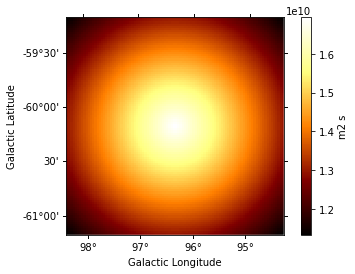

In [7]:
exposure = make_map_exposure_true_energy(
    pointing=pointing, livetime=livetime, aeff=irfs["aeff"], geom=geom
)
exposure.slice_by_idx({"energy": 3}).plot(add_cbar=True);

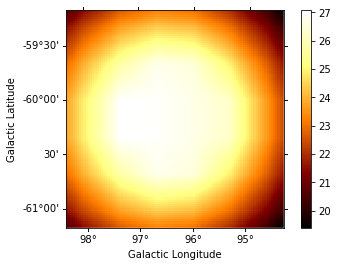

In [8]:
background = make_map_background_irf(
    pointing=pointing, ontime=livetime, bkg=irfs["bkg"], geom=geom
)
background.slice_by_idx({"energy": 3}).plot(add_cbar=True);

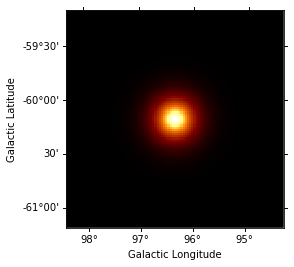

In [9]:
psf = irfs["psf"].to_energy_dependent_table_psf(theta=offset)
psf_kernel = PSFKernel.from_table_psf(psf, geom, max_radius=1 * u.deg)
psf_kernel.psf_kernel_map.sum_over_axes().plot(stretch="log");

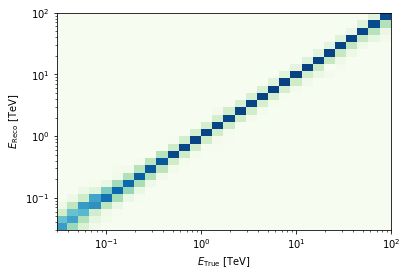

In [10]:
edisp = irfs["edisp"].to_energy_dispersion(
    offset=offset, e_reco=axis.edges * axis.unit, e_true=axis.edges * axis.unit
)
edisp.plot_matrix();

## Build model

**Declare parameters for our galactic DM model**

If we want to do the analysis with an integrated J factor, then give as an input of the DMAnnihilModel.

<div class="burk">
Good to ask to DMEP group: is there any feature characteristic to other targets (GC, GH, LMC) that should be interesting/easy/usable to include ?</div><i class="fa fa-lightbulb-o "></i>

In [11]:
JFAC = 3.41e19 * u.Unit("GeV2 cm-5") # <--- point source / may be also a 2D map
mDM = 5000*u.Unit("GeV")
channel = "b"

**Declare special parameters for our extragalactic DM model**

If we want to perform DM searches on extragalactic objects, then we can give redshift and an EBL model (already in Gammapy) as input also for DMAnnihilModel

In [12]:
#redshift = 0.5
#dominguez = Absorption.read_builtin('dominguez').table_model(redshift)

**Define Spectral User Model**

https://docs.gammapy.org/0.10/notebooks/spectrum_models.html#User-defined-model

This model allows to compute DM annihilation fluxes. If we want to do the analysis where we're taking the integrated J factor, then give as an input of the DMAnnihilModel. If we intend to perform 2D analysis, then the differential Jfactor would be load as a FITS file inside the spatial_model(SkyDiffuseMap), in this case DMAnnihilModel would only compute the spectral part of the model. 

<div class="girk">
We still need to input the redshift dependence (in the Primary_Flux)
Another good change for the PrimaryFlux is adding the possibility of Branching Ratio (?) Also adding the k=majorana/Dirac (as something optional)</div><i class="fa fa-lightbulb-o "></i>

In [13]:
class DMAnnihilModel(models.SpectralModel):
    def __init__(self, mass, channel, scale=1, jfactor=1, EBL=None):
        self.parameters = Parameters(
            [
                Parameter("scale", scale),
            ]
        )
        self.jfactor = jfactor
        self.mass = mass
        self.table_model = PrimaryFlux(mass, channel=channel).table_model
#       deal with EBL thing = 1
        
    def evaluate(self, energy, scale):
        flux = (
            scale 
            * self.jfactor
            * 3e-26 * u.Unit("cm3 s-1") # THERMAL_RELIC_CROSS_SECTION 
            * self.table_model.evaluate(energy=energy, norm=1)
#            * self.EBL.evaluate(energy=energy, norm=1)
            / self.mass
            / self.mass
            / (8 * np.pi)
        )
        return flux

When the class is implemented in Gammapy, it would have the function evaluate. As the DMAnnihilModel is a gammapy SpectralModel, it will inherit the integral method, so the we can get rid of the compute_dm_flux function already in gammapy.

**Define 3D Sky Model**

When Jfactor is integrated (point-like approximation) then needs to be given to de DMAnnihilModel, If not, we would use a SkyDiffuseMap to read the differential Jfactor from the fits files.

In [14]:
flux_model = DMAnnihilModel(
    mass=mDM, channel=channel, scale=1, jfactor=JFAC
)
spatial_model = SkyPointSource(lat_0=GLAT, lon_0=GLON)  # <--- because JFactor is a number
sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=flux_model
)

## Evaluate and display our 3D model simulation

In [15]:
background_model = BackgroundModel(background)

This part is going to change a lot. Work on progress for putting all this deriving IRFs maps and simulating the counts just in one function SimulateDataSet

In [16]:
simulate_dataset = MapDataset(
    model=sky_model,
    exposure=exposure,
    psf=psf_kernel,
    edisp=edisp,
    background_model=background_model,
)

In [17]:
npred_map = simulate_dataset.npred()

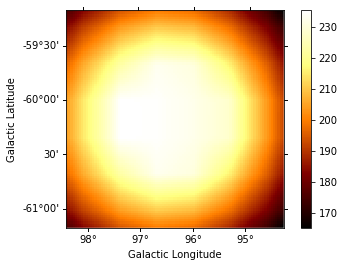

In [18]:
npred_map.sum_over_axes().plot(add_cbar=True);

BAD WAY OF TRYING SOLVE NEGATIVE SIGMA_V: set a criterium for the mapcounts once randomized, so if there are small signal counts we dismiss the realization

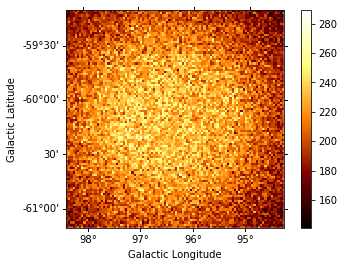

In [19]:
rng = np.random.RandomState(seed=int(time.time()))
counts = rng.poisson(npred_map.data)
counts_map = WcsNDMap(geom, counts)
counts_map.sum_over_axes().plot(add_cbar=True);

## Fit model loop

This function will surely evolve, in fact in cell 26 is already defined using likelihood profiles, and that's the way we should go

In [20]:
def ts_diff(x):
    result.parameters["scale"].value = x
    stat = fit.total_stat(result.parameters)
    return (stat - stat_best_fit) - 2.71

**Fit for different mDM and channels**

In [21]:
#We do not want to fit the background in this case, so we will freeze the parameters
background_model.parameters["norm"].value = 1.0
background_model.parameters["norm"].frozen = True
background_model.parameters["tilt"].frozen = True

<div class="burk">
I'm not sure we don't want to fit the backgroud...</div><i class="fa fa-lightbulb-o "></i>

The cell 24 will evolve into a class, where the loops in the channels and in the mass will propbably will considered as a function, and will return the parameters, profile likelihood and corresponding upper limits of the fitting

We need to solve the likelihood BIG problem: the fitting doesn't seem to work. Our main guesses are (1) the shape of the likehood is not good for dark matter and we need to follow the likelihood of the dm conventions instead the one that now minuit is using (check how fermipy does ?) (2) Adding of the nuisence parameters (3) the bayesian probability so then sigma_v has physical meaningful values from the beggining

In [22]:
%%time
massval_list = [70, 200, 500, 5000, 10000, 50000, 100000]
channel_list = ["b"] 
NumberOfRuns = 9

# data structure
columns = ["run", "mass", "sigma_v"]
df = pd.DataFrame(columns=columns)

# loop
for run in range(NumberOfRuns)[0:1]:

    rng = np.random.RandomState(seed=1+int(time.time()))
    counts = rng.poisson(npred_map.data)
    counts_map = WcsNDMap(geom, counts)
    
    print('#-----------------------------------------')
    print("RUN", run+1)
    for ch in channel_list:
        for mass in massval_list:
            print("mass", mass)
            
            # ------- TUNE IN MODEL IN MASS/CHANNEL RANGE
            spectral_model = DMAnnihilModel(
                            mass = mass * u.GeV,
                            channel= ch,
                            scale = 1,
                            jfactor = JFAC,
                            )
            model3D = SkyModel(
                            spatial_model=spatial_model, spectral_model=spectral_model
                            )
            
            # ------- FIT TO FIXED MODEL
            model3D.parameters['lat_0'].frozen=True
            model3D.parameters['lon_0'].frozen=True

            dataset = MapDataset(
                model=model3D,
                counts=counts_map,
                exposure=exposure,
                background_model=background_model,
                psf=psf_kernel,
                edisp=edisp
            )
            
            fit = Fit(dataset)
            fit.datasets.parameters.apply_autoscale = False
            result = fit.run()

            stat_best_fit = result.total_stat
            scale_best = result.parameters["scale"].value
            print(scale_best)

            max_scan = scale_best + 4*result.parameters.error("scale")*result.parameters["scale"].scale
            scale_f = brentq(ts_diff, scale_best, max_scan, maxiter=100, rtol=1e-5)
            sigma_v = scale_f * 3e-26 # THERMAL_RELIC_CROSS_SECTION
            print(scale_f)
            
            df = df.append(
                {"run": run, "mass": mass, "sigma_v": sigma_v},
                ignore_index=True,
            )
            print("sigma_v", sigma_v)

#-----------------------------------------
RUN 1
mass 70
-31.68062693951358
362.05820639999394
sigma_v 1.0861746191999819e-23
mass 200
16.765468128667447
101.57072388882173
sigma_v 3.047121716664652e-24
mass 500
-9.801319379174954
33.587523997384466
sigma_v 1.007625719921534e-24
mass 5000
-3.946765857141094
36.07771988648135
sigma_v 1.0823315965944405e-24
mass 10000
-8.588192581186053
40.19757222342996
sigma_v 1.2059271667028989e-24
mass 50000
-56.125866768758776
52.51751915400539
sigma_v 1.5755255746201618e-24
mass 100000
-50.341984506592325
131.36008006370673
sigma_v 3.940802401911202e-24
CPU times: user 24.1 s, sys: 1.09 s, total: 25.2 s
Wall time: 26.8 s


In [23]:
#counts_map.plot_interactive(add_cbar=True);

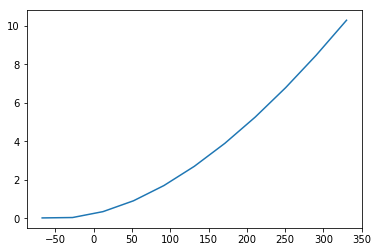

In [24]:
#p = fit.likelihood_profile(parameter="scale", reoptimize=True)
p = fit.likelihood_profile(parameter="scale")
plt.plot(p["values"], p["likelihood"] - result.total_stat)

In [25]:
model3D.parameters.to_table()

name,value,error,unit,min,max,frozen
str5,float64,float64,str3,float64,float64,bool
lon_0,9.634e+01,nan,deg,-1.800e+02,1.800e+02,True
lat_0,-6.019e+01,nan,deg,-9.000e+01,9.000e+01,True
scale,1.314e+02,nan,,nan,nan,False


## Plot obtained results

In [26]:
df[["run"]] = df[["run"]].astype(int)
df[["mass"]] = df[["mass"]].astype(int)

stats = df.groupby(["mass"]).mean()
stats_std = df.groupby(["mass"]).std()
stats.drop(["run"], axis=1, inplace=True)
stats_std.drop(["run"], axis=1, inplace=True)
#stats_std.columns = ["std_sigma_v"]

#stats = pd.merge(stats, stats_std, left_index=True, right_index=True)
stats

,sigma_v
mass,
70,1.086175e-23
200,3.047122e-24
500,1.007626e-24
5000,1.082332e-24
10000,1.205927e-24
50000,1.575526e-24
100000,3.940802e-24


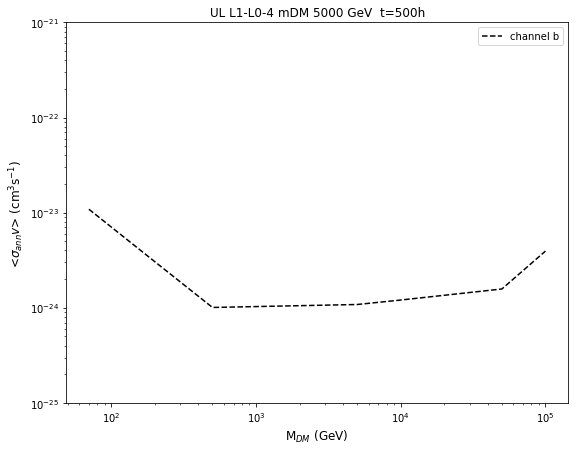

In [27]:
fig, ax1 = plt.subplots(1, figsize=(9, 7))

ax1.loglog(
    stats.index.values,
    stats["sigma_v"],
    color="k",
    ls="--",
    label='channel b'
)

ax1.set_xlabel("M$_{DM}$ (GeV)", fontsize=12)
ax1.set_ylabel(r"<$\sigma_{ann}v$> (cm$^3$s$^{-1}$)", fontsize=12)
ax1.set_ylim(1e-25, 1e-21)
ax1.set_title("UL L1-L0-4 mDM 5000 GeV  t=500h")
ax1.legend()